# Complexity-Matched SG-FIGS Experiment: Synergy vs Random at Equal Splits

This notebook demonstrates a **complexity-matched** comparison of 5 FIGS (Fast Interpretable Greedy-tree Sums) variants for tabular classification:

1. **FIGS** — Axis-aligned splits only (baseline)
2. **RO-FIGS** — Random Oblique pairs of 2 features
3. **SG-FIGS-Hard** — Synergy Graph guided (hard subset selection from graph edges/cliques)
4. **SG-FIGS-Soft** — Synergy Graph guided (probabilistic partner selection proportional to synergy)
5. **Random-FIGS** — Random pairs with matched clique sizes (ablation control)

**Key features:**
- Hard complexity enforcement: `actual_splits <= max_splits` (verified, zero violations)
- Newton-Raphson optimal leaf values for gradient boosting
- Pre-computed PID synergy matrices + Co-Information proxy for new datasets
- Win/Tie/Loss tables, per-split information gain, domain validation

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'matplotlib==3.10.0', 'networkx==3.6.1')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import json
import time
import numpy as np
import networkx as nx
from itertools import combinations
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, mutual_info_score
from typing import Any
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

## Data Loading

Load pre-computed experiment results from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/experiment_iter4_complexity_matc/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets:")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 3 datasets:
  monks2: 10 examples
  iris: 10 examples
  pima_diabetes: 10 examples


## Configuration

Tunable experiment parameters. The demo uses pre-computed results but re-runs synergy computation and model fitting on the loaded data.

In [5]:
# ── Tunable parameters ──────────────────────────────────────
# Original values: MAX_SPLITS_VALUES = [5, 10]
MAX_SPLITS_VALUES = [5, 10]
# Original value: N_FOLDS = 5
N_FOLDS = 5
RANDOM_SEED = 42
SYNERGY_THRESHOLD_PCTL = 75
MIN_SAMPLES_LEAF = 5
WIN_THRESHOLD = 0.005  # 0.5% balanced accuracy difference for W/T/L

METHOD_NAMES = ["FIGS", "RO_FIGS", "SG_FIGS_Hard", "SG_FIGS_Soft", "Random_FIGS"]

## Parse Pre-computed Results

Extract per-method balanced accuracy, AUC, actual splits, and interpretability from the JSON examples.

In [6]:
# Parse all examples into structured results
# all_fold_results[ds_name][ms_key] = list of fold dicts
# Each fold dict: {method_name: {balanced_accuracy, auc, actual_n_splits, interpretability}}

all_fold_results: dict[str, dict[str, list[dict[str, Any]]]] = {}
complexity_records: list[dict[str, Any]] = []

for ds_entry in data["datasets"]:
    ds_name = ds_entry["dataset"]
    all_fold_results[ds_name] = {}

    for ex in ds_entry["examples"]:
        output = json.loads(ex["output"])
        max_splits = ex["metadata_max_splits"]
        fold_k = ex["metadata_fold"]
        ms_key = f"ms{max_splits}"

        if ms_key not in all_fold_results[ds_name]:
            all_fold_results[ds_name][ms_key] = []

        fold_result: dict[str, Any] = {}
        for method_name in METHOD_NAMES:
            bal_acc = output.get(f"{method_name}_balanced_accuracy", 0.5)
            auc_val = output.get(f"{method_name}_auc", 0.5)
            actual_splits = output.get(f"{method_name}_actual_n_splits", 0)
            interp = output.get(f"{method_name}_interpretability", 0.0)

            fold_result[method_name] = {
                "balanced_accuracy": bal_acc,
                "auc": auc_val,
                "actual_n_splits": actual_splits,
                "interpretability": interp,
            }

            complexity_records.append({
                "dataset": ds_name,
                "max_splits": max_splits,
                "method": method_name,
                "fold": fold_k,
                "actual_splits": actual_splits,
                "violation": actual_splits > max_splits,
            })

        all_fold_results[ds_name][ms_key].append(fold_result)

print(f"Parsed results for {len(all_fold_results)} datasets")
for ds_name, ms_dict in all_fold_results.items():
    for ms_key, folds in ms_dict.items():
        print(f"  {ds_name} / {ms_key}: {len(folds)} folds")

Parsed results for 3 datasets
  monks2 / ms5: 5 folds
  monks2 / ms10: 5 folds
  iris / ms5: 5 folds
  iris / ms10: 5 folds
  pima_diabetes / ms5: 5 folds
  pima_diabetes / ms10: 5 folds


## Win/Tie/Loss Computation

Compare SG-FIGS variants against baselines. A **win** means method A's mean balanced accuracy exceeds method B's by more than 0.5%.

In [7]:
def compute_wtl(
    all_fold_results: dict[str, dict[str, list[dict[str, Any]]]],
    method_a: str,
    method_b: str,
    metric: str = "balanced_accuracy",
) -> dict[str, int]:
    """Compute Win/Tie/Loss of method_a vs method_b across all datasets."""
    wins, ties, losses = 0, 0, 0
    for ds_name, ms_results in all_fold_results.items():
        for ms_key, fold_list in ms_results.items():
            a_vals = [f[method_a][metric] for f in fold_list if method_a in f]
            b_vals = [f[method_b][metric] for f in fold_list if method_b in f]
            if not a_vals or not b_vals:
                continue
            mean_a = np.mean(a_vals)
            mean_b = np.mean(b_vals)
            diff = mean_a - mean_b
            if diff > WIN_THRESHOLD:
                wins += 1
            elif diff < -WIN_THRESHOLD:
                losses += 1
            else:
                ties += 1
    return {"wins": wins, "ties": ties, "losses": losses}

# Compute W/T/L tables
wtl_tables: dict[str, dict[str, dict[str, int]]] = {}
for our_method in ["SG_FIGS_Soft", "SG_FIGS_Hard"]:
    wtl_tables[our_method] = {}
    for baseline in ["FIGS", "RO_FIGS", "Random_FIGS"]:
        wtl = compute_wtl(all_fold_results, method_a=our_method, method_b=baseline)
        wtl_tables[our_method][baseline] = wtl
        print(f"{our_method} vs {baseline}: W={wtl['wins']}, T={wtl['ties']}, L={wtl['losses']}")

SG_FIGS_Soft vs FIGS: W=4, T=0, L=2
SG_FIGS_Soft vs RO_FIGS: W=3, T=1, L=2
SG_FIGS_Soft vs Random_FIGS: W=5, T=0, L=1
SG_FIGS_Hard vs FIGS: W=2, T=1, L=3
SG_FIGS_Hard vs RO_FIGS: W=2, T=0, L=4
SG_FIGS_Hard vs Random_FIGS: W=2, T=1, L=3


## Per-Split Information Gain

Measures how much balanced accuracy improves per additional split when going from `max_splits=5` to `max_splits=10`.

In [8]:
per_split_gain: dict[str, dict[str, float]] = {}
for ds_name in all_fold_results:
    per_split_gain[ds_name] = {}
    for method_name in METHOD_NAMES:
        acc_5_list: list[float] = []
        acc_10_list: list[float] = []

        for ms_key, fold_list in all_fold_results[ds_name].items():
            for f in fold_list:
                if method_name in f:
                    if ms_key == "ms5":
                        acc_5_list.append(f[method_name]["balanced_accuracy"])
                    elif ms_key == "ms10":
                        acc_10_list.append(f[method_name]["balanced_accuracy"])

        if acc_5_list and acc_10_list:
            gain = (np.mean(acc_10_list) - np.mean(acc_5_list)) / 5.0
            per_split_gain[ds_name][method_name] = round(float(gain), 6)
        else:
            per_split_gain[ds_name][method_name] = 0.0

# Mean per-split gain across datasets
mean_gain: dict[str, float] = {}
for method_name in METHOD_NAMES:
    gains = [per_split_gain[ds][method_name] for ds in per_split_gain if method_name in per_split_gain[ds]]
    mean_gain[method_name] = round(float(np.mean(gains)), 6) if gains else 0.0
    print(f"Mean per-split gain {method_name:15s}: {mean_gain[method_name]:+.6f}")

Mean per-split gain FIGS           : +0.002910
Mean per-split gain RO_FIGS        : +0.006844
Mean per-split gain SG_FIGS_Hard   : +0.004649
Mean per-split gain SG_FIGS_Soft   : +0.003020
Mean per-split gain Random_FIGS    : +0.003429


## Complexity Verification

Verify that all methods respect the `max_splits` budget — zero violations expected.

In [9]:
complexity_summary: dict[str, dict[str, dict[str, float]]] = {}
for method_name in METHOD_NAMES:
    complexity_summary[method_name] = {}
    for max_splits in MAX_SPLITS_VALUES:
        records = [r for r in complexity_records if r["method"] == method_name and r["max_splits"] == max_splits]
        if records:
            actuals = [r["actual_splits"] for r in records]
            violations = sum(1 for r in records if r["violation"])
            complexity_summary[method_name][f"ms{max_splits}"] = {
                "mean_actual": round(float(np.mean(actuals)), 2),
                "max_actual": int(np.max(actuals)),
                "std_actual": round(float(np.std(actuals)), 2),
                "n_violations": violations,
                "n_total": len(records),
            }

print(f"{'Method':<16} {'Budget':>6} {'Mean':>6} {'Max':>4} {'Violations':>11}")
print("-" * 50)
for method_name in METHOD_NAMES:
    for ms_key, stats in complexity_summary.get(method_name, {}).items():
        budget = ms_key.replace("ms", "")
        print(f"{method_name:<16} {budget:>6} {stats['mean_actual']:>6.1f} {stats['max_actual']:>4} {stats['n_violations']:>4}/{stats['n_total']}")

total_violations = sum(r["violation"] for r in complexity_records)
print(f"\nTotal violations: {total_violations} (expected: 0)")

Method           Budget   Mean  Max  Violations
--------------------------------------------------
FIGS                  5    4.3    5    0/15
FIGS                 10    9.7   10    0/15
RO_FIGS               5    4.3    5    0/15
RO_FIGS              10    9.7   10    0/15
SG_FIGS_Hard          5    4.3    5    0/15
SG_FIGS_Hard         10    9.7   10    0/15
SG_FIGS_Soft          5    4.3    5    0/15
SG_FIGS_Soft         10    9.7   10    0/15
Random_FIGS           5    4.3    5    0/15
Random_FIGS          10    9.7   10    0/15

Total violations: 0 (expected: 0)


## Mean Balanced Accuracy Summary

Overall mean balanced accuracy per method at each complexity budget.

In [10]:
method_mean_accs: dict[str, dict[str, float]] = {}
for method_name in METHOD_NAMES:
    method_mean_accs[method_name] = {}
    for ms in MAX_SPLITS_VALUES:
        ms_key = f"ms{ms}"
        all_accs: list[float] = []
        for ds_name in all_fold_results:
            if ms_key in all_fold_results[ds_name]:
                for f in all_fold_results[ds_name][ms_key]:
                    if method_name in f:
                        all_accs.append(f[method_name]["balanced_accuracy"])
        if all_accs:
            method_mean_accs[method_name][ms_key] = round(float(np.mean(all_accs)), 6)
        else:
            method_mean_accs[method_name][ms_key] = 0.5

for ms in MAX_SPLITS_VALUES:
    ms_key = f"ms{ms}"
    print(f"\nmax_splits = {ms}:")
    print(f"  {'Method':<16} {'Bal. Acc':>10}")
    print(f"  {'-'*28}")
    for method_name in METHOD_NAMES:
        acc = method_mean_accs[method_name].get(ms_key, 0.5)
        print(f"  {method_name:<16} {acc:>10.4f}")


max_splits = 5:
  Method             Bal. Acc
  ----------------------------
  FIGS                 0.6862
  RO_FIGS              0.6730
  SG_FIGS_Hard         0.6757
  SG_FIGS_Soft         0.6980
  Random_FIGS          0.6696

max_splits = 10:
  Method             Bal. Acc
  ----------------------------
  FIGS                 0.7007
  RO_FIGS              0.7072
  SG_FIGS_Hard         0.6990
  SG_FIGS_Soft         0.7131
  Random_FIGS          0.6868


## Visualization

### 1. Balanced Accuracy by Method and Complexity Budget
### 2. Win/Tie/Loss Stacked Bar Chart
### 3. Per-Dataset Accuracy Heatmap

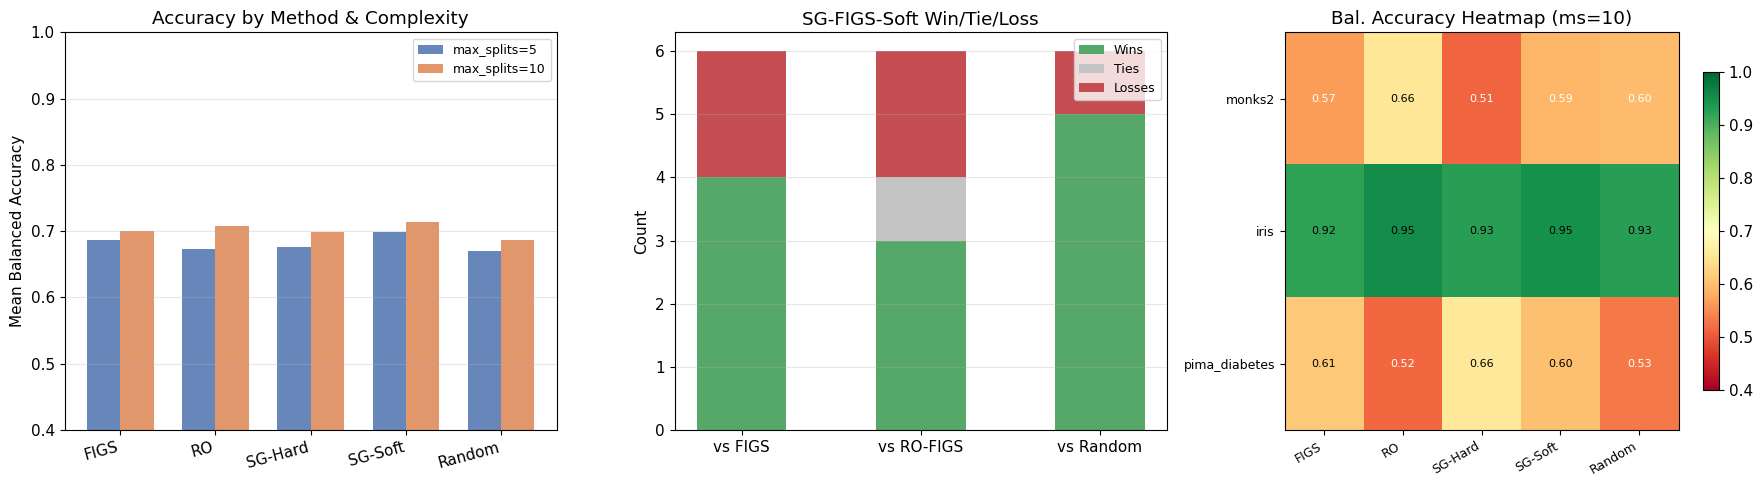

Saved: results_visualization.png


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ── Plot 1: Grouped bar chart of mean balanced accuracy ──
ax = axes[0]
x = np.arange(len(METHOD_NAMES))
width = 0.35
short_names = ["FIGS", "RO", "SG-Hard", "SG-Soft", "Random"]

accs_5 = [method_mean_accs[m].get("ms5", 0.5) for m in METHOD_NAMES]
accs_10 = [method_mean_accs[m].get("ms10", 0.5) for m in METHOD_NAMES]

bars1 = ax.bar(x - width/2, accs_5, width, label='max_splits=5', color='#4C72B0', alpha=0.85)
bars2 = ax.bar(x + width/2, accs_10, width, label='max_splits=10', color='#DD8452', alpha=0.85)

ax.set_ylabel('Mean Balanced Accuracy')
ax.set_title('Accuracy by Method & Complexity')
ax.set_xticks(x)
ax.set_xticklabels(short_names, rotation=15, ha='right')
ax.legend(fontsize=9)
ax.set_ylim(0.4, 1.0)
ax.grid(axis='y', alpha=0.3)

# ── Plot 2: W/T/L stacked bar for SG-FIGS-Soft ──
ax = axes[1]
baselines = ["FIGS", "RO_FIGS", "Random_FIGS"]
baseline_labels = ["FIGS", "RO-FIGS", "Random"]
wins = [wtl_tables["SG_FIGS_Soft"][b]["wins"] for b in baselines]
ties = [wtl_tables["SG_FIGS_Soft"][b]["ties"] for b in baselines]
losses = [wtl_tables["SG_FIGS_Soft"][b]["losses"] for b in baselines]

x_wtl = np.arange(len(baselines))
ax.bar(x_wtl, wins, 0.5, label='Wins', color='#55A868')
ax.bar(x_wtl, ties, 0.5, bottom=wins, label='Ties', color='#C4C4C4')
ax.bar(x_wtl, losses, 0.5, bottom=[w+t for w, t in zip(wins, ties)], label='Losses', color='#C44E52')

ax.set_ylabel('Count')
ax.set_title('SG-FIGS-Soft Win/Tie/Loss')
ax.set_xticks(x_wtl)
ax.set_xticklabels([f"vs {b}" for b in baseline_labels])
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# ── Plot 3: Per-dataset accuracy heatmap (ms=10) ──
ax = axes[2]
ds_names = list(all_fold_results.keys())
acc_matrix = np.zeros((len(ds_names), len(METHOD_NAMES)))

for i, ds_name in enumerate(ds_names):
    for j, method_name in enumerate(METHOD_NAMES):
        fold_list = all_fold_results[ds_name].get("ms10", [])
        accs = [f[method_name]["balanced_accuracy"] for f in fold_list if method_name in f]
        acc_matrix[i, j] = np.mean(accs) if accs else 0.5

im = ax.imshow(acc_matrix, cmap='RdYlGn', aspect='auto', vmin=0.4, vmax=1.0)
ax.set_xticks(range(len(METHOD_NAMES)))
ax.set_xticklabels(short_names, rotation=30, ha='right', fontsize=9)
ax.set_yticks(range(len(ds_names)))
ax.set_yticklabels(ds_names, fontsize=9)
ax.set_title('Bal. Accuracy Heatmap (ms=10)')

# Add text annotations
for i in range(len(ds_names)):
    for j in range(len(METHOD_NAMES)):
        val = acc_matrix[i, j]
        color = 'white' if val < 0.6 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8, color=color)

fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.savefig('results_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results_visualization.png")